# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

/usr/local/anaconda3/envs/data_science/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
DATA_GRID_INPUT_DIR = '.'

In [4]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [5]:
h = 28 # Prediction horizon
max_lags = 65 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


## 1.4 Cuting the dataset

In [6]:
# Determine first needed day for training
# data = data.loc[data['date'] >= FIRST_LOADING_DAY] # So we will have space for lag and rolling features
# gc.collect()
# data.shape

## 1.5 Computing weights (simulating WMRSSE cost function)

We set weights for training samples, based on competition's weighting methodology. It is hard to simulate it fully, 
but we try to select more valuable items, based on sales for last 28 days in train period. We use agregated sales for 
each state and department and then compute weights based on these values.

In [38]:
# Selecting last 28 days for calculations
last_28d = data.loc[data.date>='2016-03-28']


In [39]:
# First convert 'sales' column to float32, 
# so the sum() number will fit into its range
last_28d['sales'] = last_28d['sales'].astype(np.float32)
total_by_state_dept = last_28d.groupby(['state_id', 'dept_id'])['sales'].sum().reset_index(name='total_by_state_dept')
total_by_id = last_28d.groupby(['item_id', 'state_id', 'dept_id'])['sales'].sum().reset_index(name='total_by_id')
last_28d = pd.merge(last_28d, total_by_state_dept, on=['state_id', 'dept_id'])
last_28d = pd.merge(last_28d, total_by_id, on=['item_id', 'state_id', 'dept_id'])
last_28d['weights'] = last_28d['total_by_id'] / last_28d['total_by_state_dept']

In [40]:
# Scale weights to have more effect from value in training
last_28d['weights'] *= 10

# Because CA items have more weight overall, 
# we also multiply them by 1.6 (based on weights from GitHub)
# TODO: If it will work, compute these values in pandas
last_28d.loc[last_28d['state_id'] == 0, 'weights'] *= 1.6

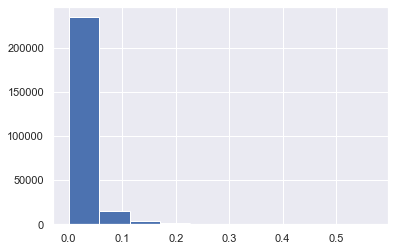

In [45]:
last_28d.loc[last_28d['state_id'] == 1, 'weights'].hist()

In [31]:
last_28d.loc[last_28d['state_id'] == 0, 'sales'].sum()

504171.0

In [29]:
last_28d.loc[last_28d['weights']>0.9].count()


id                     84
item_id                84
dept_id                84
store_id               84
cat_id                 84
state_id               84
d                      84
sales                  84
date                   84
wm_yr_wk               84
weekday                84
wday                   84
month                  84
year                   84
event_name_1           84
event_type_1           84
event_name_2           84
event_type_2           84
snap_CA                84
snap_TX                84
snap_WI                84
sell_price             84
total_by_state_dept    84
total_by_id            84
weights                84
dtype: int64

In [ ]:
last_28d.loc[last_28d['total_by_id'] > 1000,'total_by_id'].count()

In [ ]:
data

# 2. Feature Engineering

## Creating features


In [ ]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
               
    # Adding lagged and rolling features
#     df_grpby_id_sales = df[["id","sales"]].groupby(["id"])["sales"]
#     for val in [1, 2, 3, 4, 5, 6, 7, 28]:
#         df[f"lag_t{val}"] = df_grpby_id_sales.shift(val).astype(np.float16)

#     SHIFT_DAYS = 1 # So we make this features starting from previous day
#     for val in [7, 14, 28]:
#         df[f"rolling_mean_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).mean()).astype(np.float16)
#         df[f"rolling_std_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).std()).astype(np.float16)        
#         df[f"rolling_max_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).max()).astype(np.float16)

    # Adding price related features
#     PRICE_WINDOW = 60
#     df_grpby_id_sell_price = df[['id','sell_price']].groupby(["id"])["sell_price"]
#     df['price_max_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).max()).astype(np.float16)
#     df['price_min_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).min()).astype(np.float16)
#     df['price_std_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).std()).astype(np.float16)
#     df['price_mean_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).mean()).astype(np.float16)

#     df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    

In [ ]:
%%time

create_features(data)

In [ ]:
data.info()

In [ ]:
data.dropna(inplace = True)
data.shape

In [ ]:
data

## Reduce mem usage of created features

In [ ]:
data = reduce_mem_usage(data)

# 3. Fit & Predict

In [ ]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

In [ ]:
train_end_dt = datetime(2016, 3, 27)
valid_end_dt = datetime(2016, 4, 24)

In [ ]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = data.columns[~data.columns.isin(useless_cols)]

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
# X_train = train[train_cols]
# y_train = train["sales"]
# %xdel train
# gc.collect()

# X_valid= data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), train_cols]
# y_valid = data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), "sales"]
# train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
X_train = data[train_cols]
y_train = data["sales"]

np.random.seed(SEED)
valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, valid_inds)

train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_train.loc[valid_inds], label = y_train.loc[valid_inds],
                        categorical_feature=cat_feats, free_raw_data=False)
del valid_inds, train_inds

del data, X_train, y_train 
gc.collect()


In [ ]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.8,
        "bagging_freq" : 1,
        'feature_fraction': 0.8,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        'verbosity': 1,
        'num_iterations' : 1200,
        'num_leaves': 2**7-1,
        "min_data_in_leaf": 2**7-1,
        'early_stopping_rounds': 125,
        'seed': SEED,
}

In [ ]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


In [ ]:
os.system('say "Training complete"')

In [ ]:
m_lgb.save_model("model.lgb")
#m_lgb = lgb.Booster(model_file='model.lgb')

In [ ]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance(), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance

In [ ]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

In [ ]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values     
    
    df['price_mean_t60'] = df.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)

    
## Creating features for test data
def create_date_features_for_test(df):
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")


In [ ]:
create_date_features_for_test(tdata)

In [ ]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    tdata.loc[tdata.date == day, "sales"] = 1.03*m_lgb.predict(tst) 


In [ ]:
os.system('say "Prediction complete"')

In [ ]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

In [ ]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission.csv",index=False)
tdata_sub.shape
